### __Notebook to verify that looking at temperature amplitude ratio is interesting for a diffusive problem in the monodirectional case__ ###


In [266]:
#Necessary imports

import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk 
from pyheatmy import * 
from pyheatmy.time_series_multiperiodic import time_series_multiperiodic

from sklearn import linear_model
from pyheatmy.core import *
import scipy

In [267]:
# On commence par créer un signal d'entrée grace à la classe time_series_multiperiodic, que l'on forcera dans la classe Synthetic_Molonari ensuite

T_riv = time_series_multiperiodic("multi_periodic")

# On regarde des variations de température sur une année, on définit une période journalière, et une période annuelle

"""Conditions limites"""
# Température de la rivière
T_riv_year_amp = 6 # °C, représente l'amplitude de variation de température annuelle
T_riv_offset = 12 + ZERO_CELSIUS # °C, représente l'offset commun de nos signaux de température
T_riv_day_amp = 1 # °C, représente l'amplitude de variation de température journalière
# Température de l'aquifère
T_aq_amp = 0
T_aq_offset = 12 + ZERO_CELSIUS
P_T_aq = -9999 # à mettre dans le init

P_T_riv_year = NDAYINYEAR * NSECINDAY # Période annuelle en mois
P_T_riv_day = NSECINDAY # Période journalière, en heures
t_debut = (2024, 4, 15, 8, 0, 0)  # (year, month, day, hour, minute, second)
t_fin = (2024, 4, 20, 8, 0, 0)
dt = int(NSECINHOUR / 4)  #On se place dans le cas d'un point de mesure toutes les quinze minutes (à moduler en fonction de l'intervale temporel considéré)
nday = 3

moinslog10IntrinK = 11
lambda_s = 2 # test cas purement advectif
rhos_cs = 4e6
range_of_minus_log_10_K = [10,11,12,13,14,15]  # The values we want to test

n = 0.1  # porosité
nb_cells=20 # nombre de cellules, une tous les 5 centimètres 
depth_sensors = [.1, .2, .3, .4]
Zbottom = 0.4
river_bed = 1.  # profondeur de la colonne en mètres
last_cell = int(9/10 * nb_cells)  # on écarte les dernières valeurs pour éviter les effets de bord
depth_cells = np.linspace(0, river_bed, nb_cells)

# Pression différentielle
dH_amp = 0
dH_offset = 0.1  # m
P_dh = -9999 #14*24*4*dt

# Bruit de mesure
sigma_meas_P = 0.001
sigma_meas_T = 0.1

name ="Couche en sable"

In [268]:
print("dt={0:.1f}s".format(dt))

dt=900.0s


Initializing time series of synthetic_MOLONARI
param_time_dates: [(2024, 4, 15, 8, 0, 0), (2024, 4, 20, 8, 0, 0), 900]
param_dH_signal: [0, -9999, 0.1]
param_T_riv_signal: [1, 86400, 285.15]
param_T_aq_signal: [0, -9999, 285.15]
sigma_meas_P: 0.001
sigma_meas_T: 0.1
Entering Hydraulic head differential generation with amplitude 0, period of -9999, offset 0.1, dt 900 --> 
constant signal

Entering T_riv generation with amplitude 1, period of 86400, offset 285.15, dt 900 --> 
periodic signal



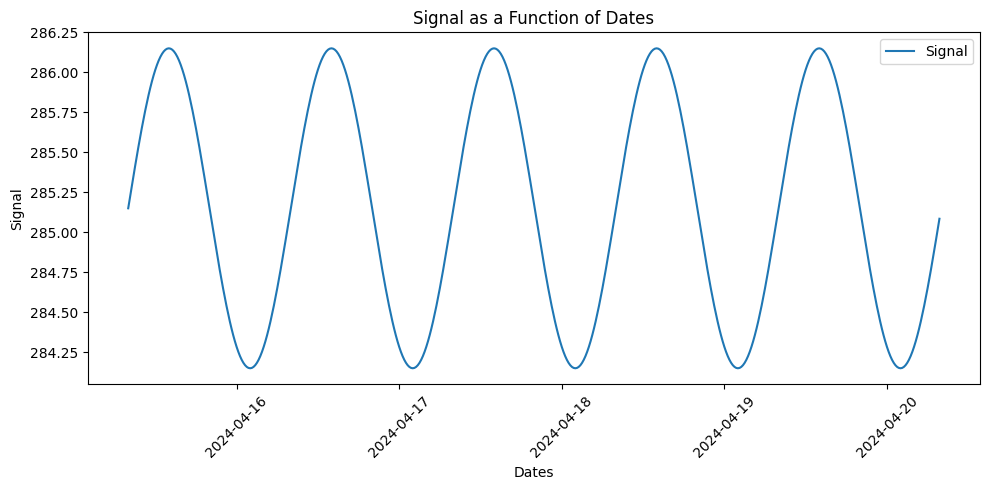

Entering T_aq generation with amplitude 0, period of -9999, offset 285.15, dt 900 --> 
constant signal

Generating Shaft with 4 sensors
4 sensors in the shaft
Temperature of Sensor 0 : [285.15       285.19905235 285.24789464 285.29631774 285.34411428
 285.3910796  285.43701257 285.48171652 285.525      285.56667767
 285.60657107 285.64450936 285.68033009 285.71387986 285.74501501
 285.77360221 285.79951905 285.82265456 285.84290965 285.8601976
 285.87444437 285.88558896 285.89358365 285.89839419 285.9
 285.89839419 285.89358365 285.88558896 285.87444437 285.8601976
 285.84290965 285.82265456 285.79951905 285.77360221 285.74501501
 285.71387986 285.68033009 285.64450936 285.60657107 285.56667767
 285.525      285.48171652 285.43701257 285.3910796  285.34411428
 285.29631774 285.24789464 285.19905235 285.15       285.10094765
 285.05210536 285.00368226 284.95588572 284.9089204  284.86298743
 284.81828348 284.775      284.73332233 284.69342893 284.65549064
 284.61966991 284.58612014 284.5

In [269]:
#Ensuite, on commence par créer un objet synthetic_MOLONARI pour pouvoir utiliser ses méthodes (et en particulier accéder à son générateur de dates)

"""Reprise du code de dmo_genData pour créer un objet synthetic_MOLONARI"""
# un dictionnaire qui facilite le paramétrage avec des variables globales définies plus haut
time_series_dict_user1 = {
    "offset":.0,
    "depth_sensors":depth_sensors,
	"param_time_dates": [t_debut, t_fin, dt], 
    "param_dH_signal": [dH_amp, P_dh, dH_offset], #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
	"param_T_riv_signal": [T_riv_day_amp, P_T_riv_day, T_riv_offset],
    "param_T_aq_signal": [T_aq_amp, P_T_aq, T_aq_offset],
    "sigma_meas_P": sigma_meas_P,
    "sigma_meas_T": sigma_meas_T, #float
}
# instanciation du simulateur de données
emu_observ_test_user1 = synthetic_MOLONARI.from_dict(time_series_dict_user1)


In [270]:
#On utilise le jeu de date précédent pour créer un signal de température multipériodique 

# signal multipériodique
'''T_riv.create_multiperiodic_signal([T_AMP_ANNUELLE, T_AMP_JOURNALIERE], [[P_an, 'm'], [P_jour, 'h']], emu_observ_test_user1._dates, dt,
                                   offset=T_MOY_ANNUELLE)'''

# simple signal
T_riv.create_multiperiodic_signal([T_riv_day_amp], [[P_T_riv_day, 's']], emu_observ_test_user1._dates, dt,
                                   offset=T_riv_offset)

# T_riv.plot() #On affiche le signal de température créé

Creating a multi-periodic signal, with the following period: [[86400, 's']] and the following amplitude: [1]
periods : [86400]


In [271]:
#On force la variable T_riv dans l'objet emu_observ_test_user1

emu_observ_test_user1._T_riv = T_riv.multi_periodic[1][:]

#Puis on applique les méthodes _generate_Shaft_Temp_series et _generate_perturb_Shaft_Temp_series pour changer les valeurs dépendante du nouveau T_riv

emu_observ_test_user1._generate_Shaft_Temp_series()
emu_observ_test_user1._generate_perturb_Shaft_Temp_series()
emu_observ_test_user1._generate_perturb_T_riv_dH_series()

Generating Shaft with 4 sensors
4 sensors in the shaft
Temperature of Sensor 0 : [285.15       285.19905235 285.24789464 285.29631774 285.34411428
 285.3910796  285.43701257 285.48171652 285.525      285.56667767
 285.60657107 285.64450936 285.68033009 285.71387986 285.74501501
 285.77360221 285.79951905 285.82265456 285.84290965 285.8601976
 285.87444437 285.88558896 285.89358365 285.89839419 285.9
 285.89839419 285.89358365 285.88558896 285.87444437 285.8601976
 285.84290965 285.82265456 285.79951905 285.77360221 285.74501501
 285.71387986 285.68033009 285.64450936 285.60657107 285.56667767
 285.525      285.48171652 285.43701257 285.3910796  285.34411428
 285.29631774 285.24789464 285.19905235 285.15       285.10094765
 285.05210536 285.00368226 284.95588572 284.9089204  284.86298743
 284.81828348 284.775      284.73332233 284.69342893 284.65549064
 284.61966991 284.58612014 284.55498499 284.52639779 284.50048095
 284.47734544 284.45709035 284.4398024  284.42555563 284.41441104
 284

In [272]:
#on génère un objet colonne à partir de l'objet emu_observ_test_user1
# modèle une couche
layers_list= layersListCreator([(name, Zbottom, moinslog10IntrinK, n, lambda_s, rhos_cs)])

print(f"Layers list: {layers_list}")

# on utilise les mesures générées précédemment dans les init "dH_measures" et "T_measures"
col_dict = {
	"river_bed": river_bed, 
    "depth_sensors": depth_sensors, #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
	"offset": .0,
    "dH_measures": emu_observ_test_user1._molonariP_data,
    "T_measures": emu_observ_test_user1._molonariT_data,
    "sigma_meas_P": sigma_meas_P,
    "sigma_meas_T": sigma_meas_T,
}
col = Column.from_dict(col_dict,verbose=False)

col._compute_solve_transi_multiple_layers(layers_list, nb_cells, verbose=False)

Layers list: [Couche en sable : ends at 0.4 m. Parametres(moinslog10IntrinK=11, n=0.1, lambda_s=2, rhos_cs=4000000.0)]


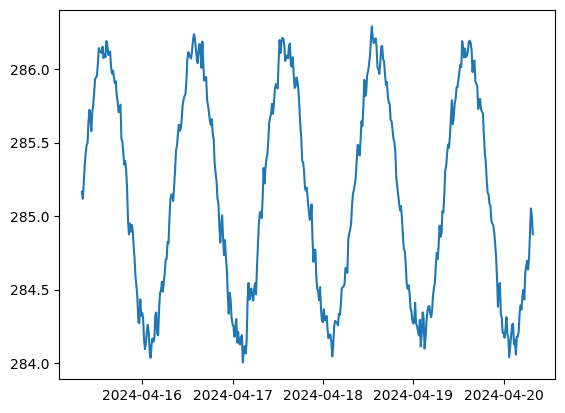

La matrice de température a pour shape : (20, 480), abscisse = température aux 20 cellules, ordonnée = température à chaque pas de temps


In [273]:
#On vérifie que les températures ont bien été modifiées dans l'objet column (en particulier que la température à profondeur nulle est bien celle de la rivière)

plt.plot(emu_observ_test_user1._dates, col._temperatures[0,:])
plt.show()

print(f"La matrice de température a pour shape : {col._temperatures.shape}, abscisse = température aux 20 cellules, ordonnée = température à chaque pas de temps")

In [274]:
#On définit une fonction pour pouvoir compiler en faisant varier la valeur de la charge (et donc le régime infiltration ou exfiltration vers la 
#rivière) ainsi que la valeur de la porosité (et donc le régime de diffusion de la chaleur - majoritairement diffusif ou advectif)

def profil_temperature(offset_H, moinslog10IntrinK): 
    time_series_dict_user1 = {
    "offset":.0,
    "depth_sensors": depth_sensors,
	"param_time_dates": [t_debut, t_fin, dt], 
    "param_dH_signal": [dH_amp, P_dh, offset_H], #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
	"param_T_riv_signal": [T_riv_day_amp, P_T_riv_day, T_riv_offset],
    "param_T_aq_signal": [T_aq_amp, P_T_aq, T_aq_offset],
    "sigma_meas_P": sigma_meas_P,
    "sigma_meas_T": sigma_meas_T, 
}
    emu_observ_test_user1 = synthetic_MOLONARI.from_dict(time_series_dict_user1)
    
    T_riv.create_multiperiodic_signal([T_riv_year_amp, T_riv_day_amp], [[P_T_riv_year, 's'], [P_T_riv_day, 's']], emu_observ_test_user1._dates, dt,
                                   offset=T_riv_offset)
    emu_observ_test_user1._T_riv = T_riv.multi_periodic[1][:]

    emu_observ_test_user1._generate_Shaft_Temp_series()
    emu_observ_test_user1._generate_perturb_Shaft_Temp_series()
    emu_observ_test_user1._generate_perturb_T_riv_dH_series()

    # modèle une couche
    layers_list= layersListCreator([(name, Zbottom, moinslog10IntrinK, n, lambda_s, rhos_cs)])

    # print(f"Layers list: {layers_list}")  # dans verbose

    # on utilise les mesures générées précédemment dans les init "dH_measures" et "T_measures"
    col_dict = {
        "river_bed": river_bed, 
        "depth_sensors": depth_sensors, #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
        "offset": .0,
        "dH_measures": emu_observ_test_user1._molonariP_data,
        "T_measures": emu_observ_test_user1._molonariT_data,
        "sigma_meas_P": sigma_meas_P,
        "sigma_meas_T": sigma_meas_T,
    }
    col = Column.from_dict(col_dict,verbose=False)
    col._compute_solve_transi_multiple_layers(layers_list, nb_cells, verbose=False)
    return col._temperatures



In [275]:
# Argument : la matrice, liste des profondeur
# Sortie : liste des amplitudes
def amplitude(T):
    amplitude_list = []
    for j in range(len(T[0,:])):
        T_max = max(T[:,j])
        T_min = min(T[:,j])
        A = (T_max - T_min) / 2
        amplitude_list.append(A)
    return amplitude_list


# Retourne ln(rapport des amplitudes) en fonction de la profondeur
def ln_amp(T):
    amplitude_list = amplitude(T)
    amplitude_array = np.array(amplitude_list)
    ln_rapport_amplitude = np.log( amplitude_array / amplitude_array[0] )
    return ln_rapport_amplitude


# Trace le ln_temp(T) en fonction de depths
def plot_ln_amp(depths, T):
    y = ln_amp(T)
    plt.plot(depths, y)
    plt.title("Logarithme du rapport des amplitudes")
    plt.xlabel("profondeur (unit)")
    plt.ylabel("ln(A_z / A_0)")
    plt.show()


# Renvoie l'instance de régression linéaire des données (profondeur, ln(rapport amplitudes))
def linear_regression(depths, T):
    y = ln_amp(T)
    return scipy.stats.linregress(depths, y)


# Trace l'interpolation linéaire en imprimant le coefficient d'exactitude
def plot_linear_regression(depths, T):
    # assert len(T) == lent(depths), "a temperature measure must be assigned to a single depth"
    X = np.array(depths).reshape(-1,1)
    Y = ln_amp(T)
    Lr = linear_regression(depths, T)
    Pearson_coefficient = Lr.rvalue
    slope = Lr.slope
    intercept = Lr.intercept
    lm = linear_model.LinearRegression()
    lm.fit(X, Y)
    plt.scatter(X, Y, color="r", marker="o", s=30)
    y_pred = lm.predict(X)
    plt.plot(X, y_pred, color="k")
    plt.xlabel("profondeur (unit)")
    plt.ylabel("ln(A_z / A_0)")
    plt.title("Régression linéaire sur le rapport des logarithmes des amplitudes")
    plt.figtext(.6, .8, "y = " + str(slope) + "x + " + str(intercept))
    plt.figtext(.6, .7, "Pearson coefficient : " + str(Pearson_coefficient))
    plt.show()


# Mosaïque des différentes courbes en fonction des valeurs de K (list_K = liste de ces valeurs)
# T est la liste des matrices de températures pour différentes valeurs de K
def plot_mosaic(depths, list_T, list_K):  
    # assert len(list_T[0]) == lent(depths), "a temperature measure must be assigned to a single depth"
    assert len(list_T) == len(list_K), 'The number of K values does not match the number a temperature matrices'
    n_rows = len(list_K)//2 + len(list_K)%2
    fig, ax = plt.subplots(n_rows, ncols=2, constrained_layout = True)
    X = np.array(depths).reshape(-1,1)
    for i in range(n_rows):
        for j in range(2):
            if 2*i + j < len(list_K):
                Y = ln_amp(list_T[2*i+j])
                Lr = linear_regression(depths, list_T[2*i+j])
                Pearson_coefficient = Lr.rvalue
                slope = Lr.slope
                intercept = Lr.intercept
                lm = linear_model.LinearRegression()
                lm.fit(X, Y)
                ax[i][j].scatter(X, Y, color="r", marker="o", s=30)
                y_pred = lm.predict(X)
                ax[i][j].plot(X, y_pred, color="k")
                ax[i][j].set_xlabel('profondeur (unit)')
                ax[i][j].set_ylabel('log(A_z / A_0)')
                ax[i][j].set_title('Rapport des ln(A_z / A_0) avec -log(K) =' + str(list_K[2*i] + j), size = 10)   
                ax[i][j].text(0.9, 0.9, "Pearson coefficient : " + str(round(Pearson_coefficient,2)), transform=ax[i][j].transAxes, ha='right', va='top')
    plt.show()


In [276]:
# test de plot_linear_regression
# Création d'un jeu de données arbitraire :

def test_plot_linear_regression():
    T = np.zeros((10,10))
    depths = [0.1 * i for i in range(10)]
    for i in range(10):
        for j in range(10):
            T[i,j] = np.sin(i) * np.exp(-j)

    plot_linear_regression(depths, T)

# test de plot_mosaic
# Création de 4 valeurs de K absurde

def test_plot_mosaic():
    T = np.zeros((10,10))
    depths = [0.1 * i for i in range(10)]
    for i in range(10):
        for j in range(10):
            T[i,j] = np.sin(i) * np.exp(-j)
    list_K = range(1,5)
    list_T = [T for _ in range(4)]

    plot_mosaic(depths,list_T,list_K)


Initializing time series of synthetic_MOLONARI
param_time_dates: [(2024, 4, 15, 8, 0, 0), (2024, 4, 20, 8, 0, 0), 900]
param_dH_signal: [0, -9999, 0.1]
param_T_riv_signal: [1, 86400, 285.15]
param_T_aq_signal: [0, -9999, 285.15]
sigma_meas_P: 0.001
sigma_meas_T: 0.1
Entering Hydraulic head differential generation with amplitude 0, period of -9999, offset 0.1, dt 900 --> 
constant signal

Entering T_riv generation with amplitude 1, period of 86400, offset 285.15, dt 900 --> 
periodic signal



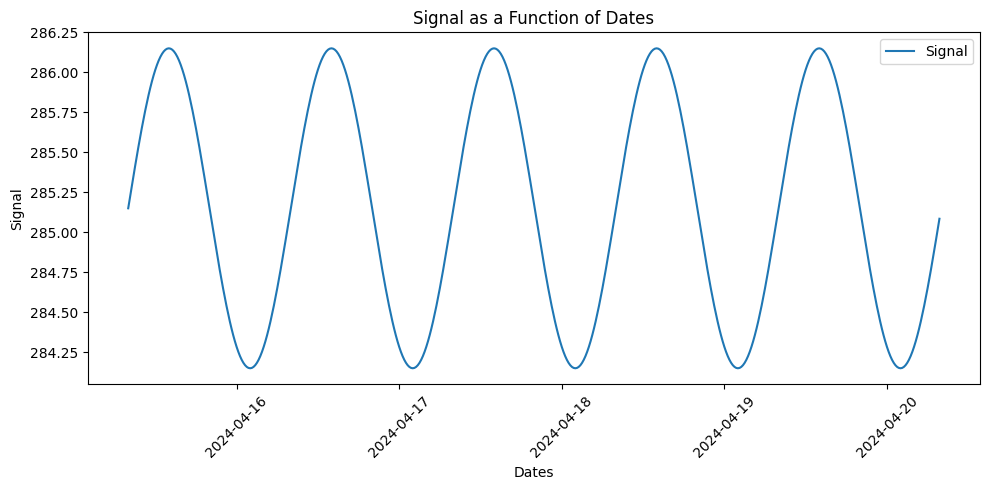

Entering T_aq generation with amplitude 0, period of -9999, offset 285.15, dt 900 --> 
constant signal

Generating Shaft with 4 sensors
4 sensors in the shaft
Temperature of Sensor 0 : [285.15       285.19905235 285.24789464 285.29631774 285.34411428
 285.3910796  285.43701257 285.48171652 285.525      285.56667767
 285.60657107 285.64450936 285.68033009 285.71387986 285.74501501
 285.77360221 285.79951905 285.82265456 285.84290965 285.8601976
 285.87444437 285.88558896 285.89358365 285.89839419 285.9
 285.89839419 285.89358365 285.88558896 285.87444437 285.8601976
 285.84290965 285.82265456 285.79951905 285.77360221 285.74501501
 285.71387986 285.68033009 285.64450936 285.60657107 285.56667767
 285.525      285.48171652 285.43701257 285.3910796  285.34411428
 285.29631774 285.24789464 285.19905235 285.15       285.10094765
 285.05210536 285.00368226 284.95588572 284.9089204  284.86298743
 284.81828348 284.775      284.73332233 284.69342893 284.65549064
 284.61966991 284.58612014 284.5

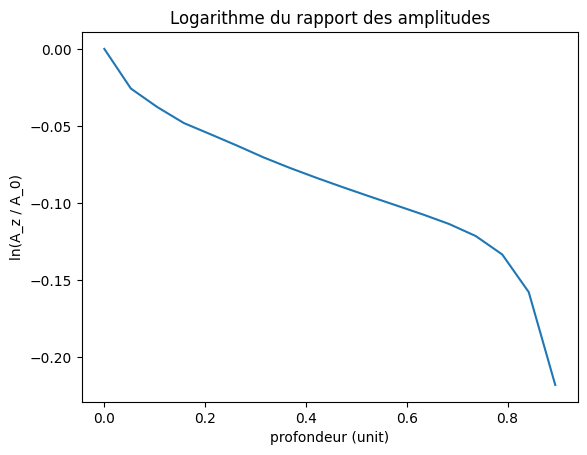

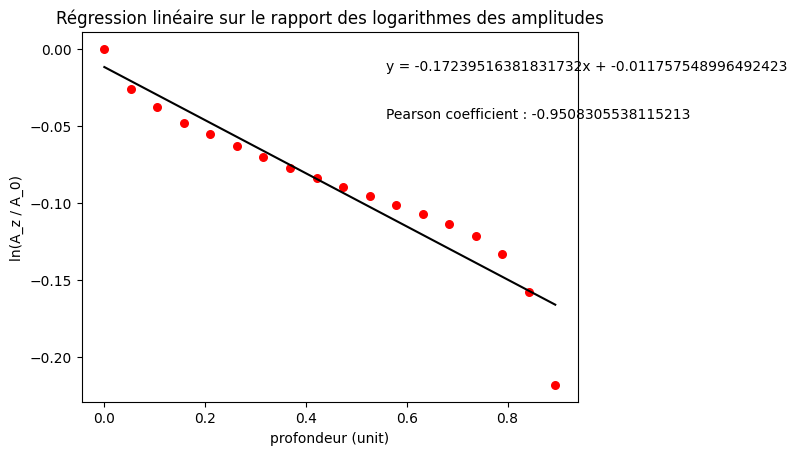

In [277]:
# On trace la température en fonction de la profondeur pour ce jour
# Il faudrait considérer une période particulière. Ici, on trace sur toute la durée mesurée

profil_temp = profil_temperature(dH_offset, moinslog10IntrinK)[:last_cell,:]
plot_ln_amp(depth_cells[0:last_cell], np.transpose(profil_temp))
plot_linear_regression(depth_cells[0:last_cell], np.transpose(profil_temp))


Initializing time series of synthetic_MOLONARI
param_time_dates: [(2024, 4, 15, 8, 0, 0), (2024, 4, 20, 8, 0, 0), 900]
param_dH_signal: [0, -9999, 0.1]
param_T_riv_signal: [1, 86400, 285.15]
param_T_aq_signal: [0, -9999, 285.15]
sigma_meas_P: 0.001
sigma_meas_T: 0.1
Entering Hydraulic head differential generation with amplitude 0, period of -9999, offset 0.1, dt 900 --> 
constant signal

Entering T_riv generation with amplitude 1, period of 86400, offset 285.15, dt 900 --> 
periodic signal



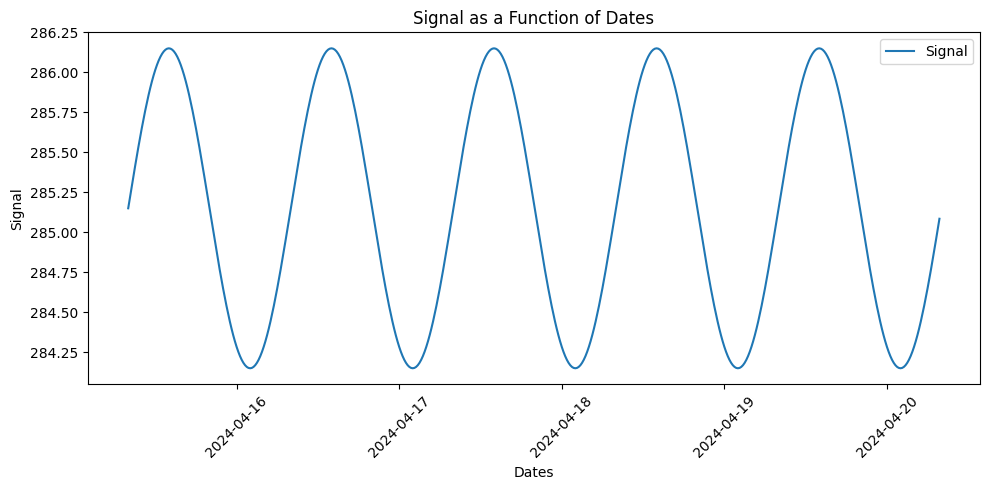

Entering T_aq generation with amplitude 0, period of -9999, offset 285.15, dt 900 --> 
constant signal

Generating Shaft with 4 sensors
4 sensors in the shaft
Temperature of Sensor 0 : [285.15       285.19905235 285.24789464 285.29631774 285.34411428
 285.3910796  285.43701257 285.48171652 285.525      285.56667767
 285.60657107 285.64450936 285.68033009 285.71387986 285.74501501
 285.77360221 285.79951905 285.82265456 285.84290965 285.8601976
 285.87444437 285.88558896 285.89358365 285.89839419 285.9
 285.89839419 285.89358365 285.88558896 285.87444437 285.8601976
 285.84290965 285.82265456 285.79951905 285.77360221 285.74501501
 285.71387986 285.68033009 285.64450936 285.60657107 285.56667767
 285.525      285.48171652 285.43701257 285.3910796  285.34411428
 285.29631774 285.24789464 285.19905235 285.15       285.10094765
 285.05210536 285.00368226 284.95588572 284.9089204  284.86298743
 284.81828348 284.775      284.73332233 284.69342893 284.65549064
 284.61966991 284.58612014 284.5

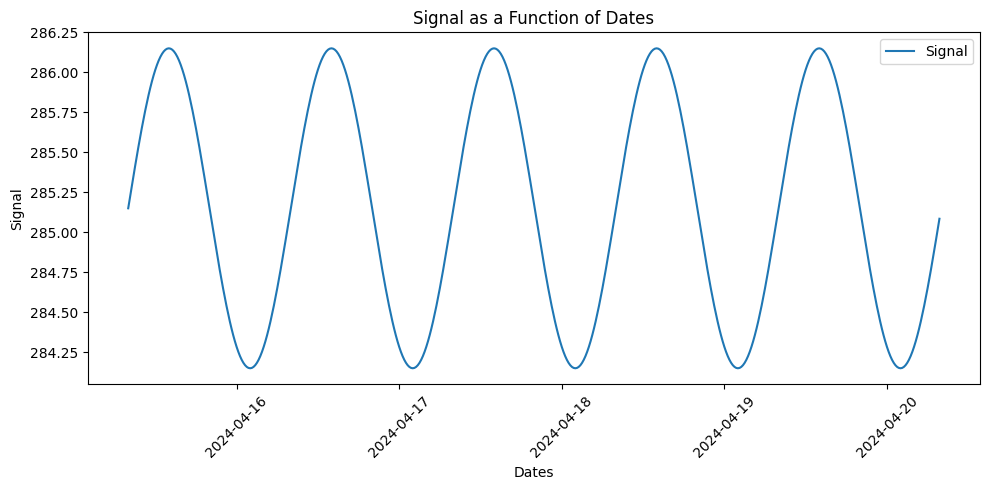

Entering T_aq generation with amplitude 0, period of -9999, offset 285.15, dt 900 --> 
constant signal

Generating Shaft with 4 sensors
4 sensors in the shaft
Temperature of Sensor 0 : [285.15       285.19905235 285.24789464 285.29631774 285.34411428
 285.3910796  285.43701257 285.48171652 285.525      285.56667767
 285.60657107 285.64450936 285.68033009 285.71387986 285.74501501
 285.77360221 285.79951905 285.82265456 285.84290965 285.8601976
 285.87444437 285.88558896 285.89358365 285.89839419 285.9
 285.89839419 285.89358365 285.88558896 285.87444437 285.8601976
 285.84290965 285.82265456 285.79951905 285.77360221 285.74501501
 285.71387986 285.68033009 285.64450936 285.60657107 285.56667767
 285.525      285.48171652 285.43701257 285.3910796  285.34411428
 285.29631774 285.24789464 285.19905235 285.15       285.10094765
 285.05210536 285.00368226 284.95588572 284.9089204  284.86298743
 284.81828348 284.775      284.73332233 284.69342893 284.65549064
 284.61966991 284.58612014 284.5

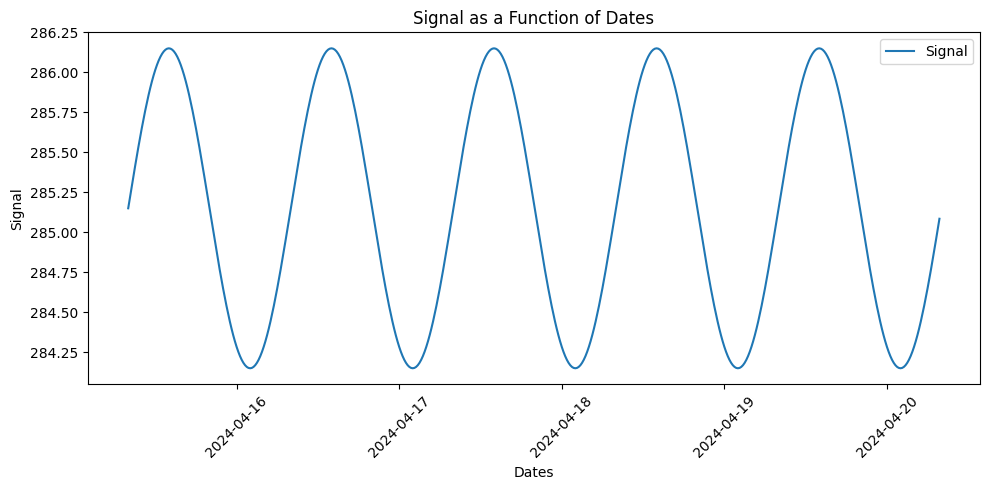

Entering T_aq generation with amplitude 0, period of -9999, offset 285.15, dt 900 --> 
constant signal

Generating Shaft with 4 sensors
4 sensors in the shaft
Temperature of Sensor 0 : [285.15       285.19905235 285.24789464 285.29631774 285.34411428
 285.3910796  285.43701257 285.48171652 285.525      285.56667767
 285.60657107 285.64450936 285.68033009 285.71387986 285.74501501
 285.77360221 285.79951905 285.82265456 285.84290965 285.8601976
 285.87444437 285.88558896 285.89358365 285.89839419 285.9
 285.89839419 285.89358365 285.88558896 285.87444437 285.8601976
 285.84290965 285.82265456 285.79951905 285.77360221 285.74501501
 285.71387986 285.68033009 285.64450936 285.60657107 285.56667767
 285.525      285.48171652 285.43701257 285.3910796  285.34411428
 285.29631774 285.24789464 285.19905235 285.15       285.10094765
 285.05210536 285.00368226 284.95588572 284.9089204  284.86298743
 284.81828348 284.775      284.73332233 284.69342893 284.65549064
 284.61966991 284.58612014 284.5

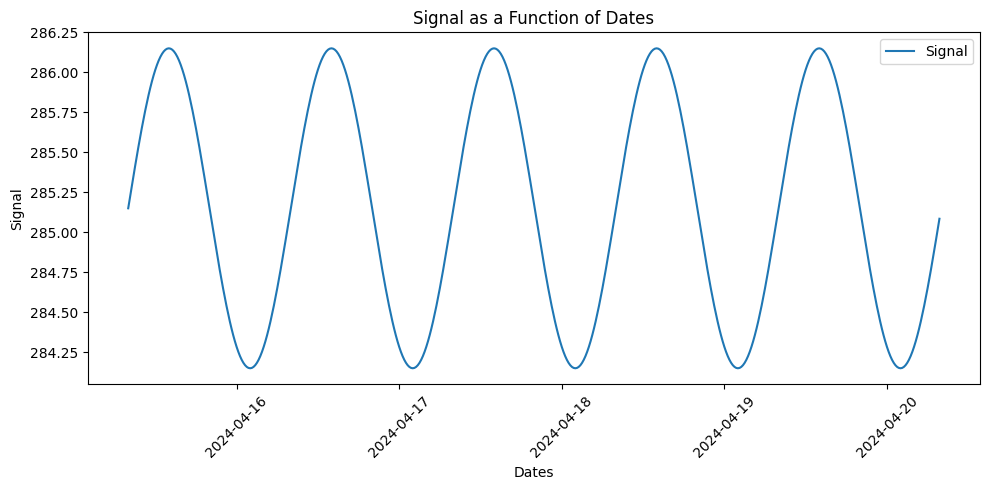

Entering T_aq generation with amplitude 0, period of -9999, offset 285.15, dt 900 --> 
constant signal

Generating Shaft with 4 sensors
4 sensors in the shaft
Temperature of Sensor 0 : [285.15       285.19905235 285.24789464 285.29631774 285.34411428
 285.3910796  285.43701257 285.48171652 285.525      285.56667767
 285.60657107 285.64450936 285.68033009 285.71387986 285.74501501
 285.77360221 285.79951905 285.82265456 285.84290965 285.8601976
 285.87444437 285.88558896 285.89358365 285.89839419 285.9
 285.89839419 285.89358365 285.88558896 285.87444437 285.8601976
 285.84290965 285.82265456 285.79951905 285.77360221 285.74501501
 285.71387986 285.68033009 285.64450936 285.60657107 285.56667767
 285.525      285.48171652 285.43701257 285.3910796  285.34411428
 285.29631774 285.24789464 285.19905235 285.15       285.10094765
 285.05210536 285.00368226 284.95588572 284.9089204  284.86298743
 284.81828348 284.775      284.73332233 284.69342893 284.65549064
 284.61966991 284.58612014 284.5

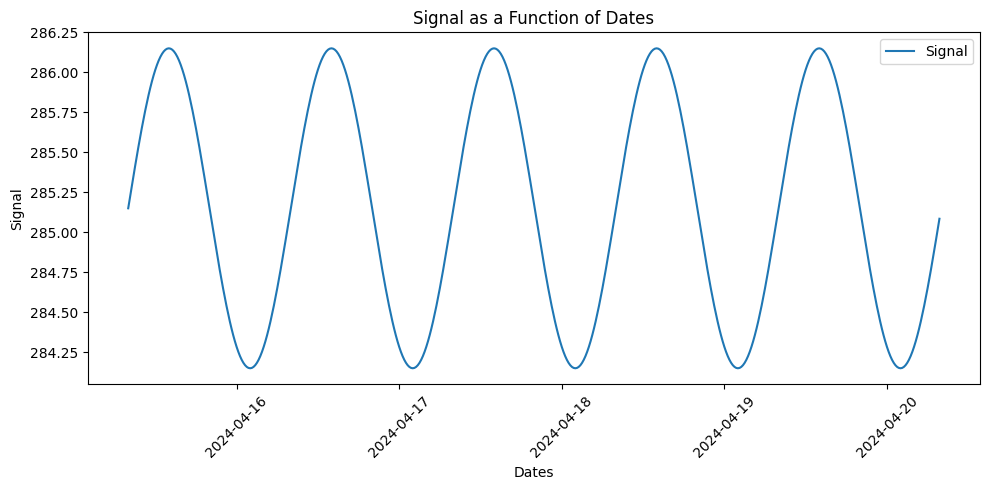

Entering T_aq generation with amplitude 0, period of -9999, offset 285.15, dt 900 --> 
constant signal

Generating Shaft with 4 sensors
4 sensors in the shaft
Temperature of Sensor 0 : [285.15       285.19905235 285.24789464 285.29631774 285.34411428
 285.3910796  285.43701257 285.48171652 285.525      285.56667767
 285.60657107 285.64450936 285.68033009 285.71387986 285.74501501
 285.77360221 285.79951905 285.82265456 285.84290965 285.8601976
 285.87444437 285.88558896 285.89358365 285.89839419 285.9
 285.89839419 285.89358365 285.88558896 285.87444437 285.8601976
 285.84290965 285.82265456 285.79951905 285.77360221 285.74501501
 285.71387986 285.68033009 285.64450936 285.60657107 285.56667767
 285.525      285.48171652 285.43701257 285.3910796  285.34411428
 285.29631774 285.24789464 285.19905235 285.15       285.10094765
 285.05210536 285.00368226 284.95588572 284.9089204  284.86298743
 284.81828348 284.775      284.73332233 284.69342893 284.65549064
 284.61966991 284.58612014 284.5

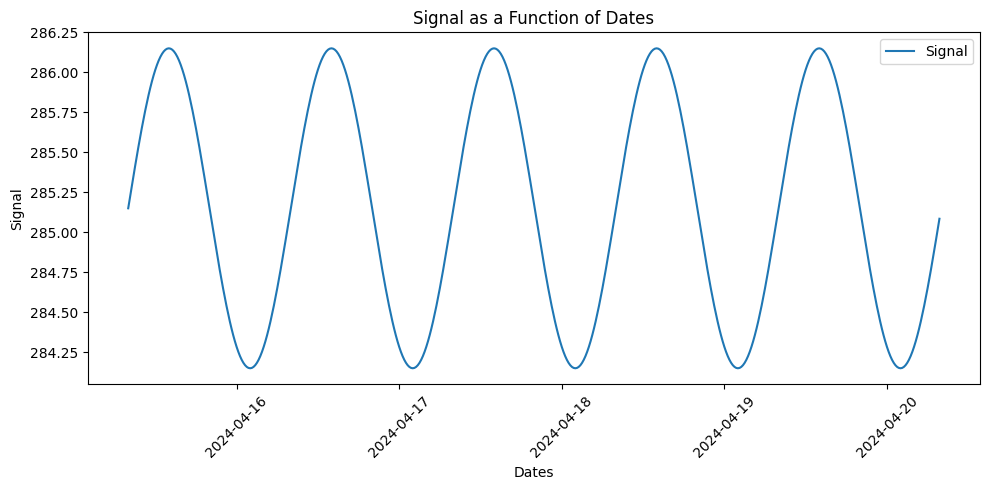

Entering T_aq generation with amplitude 0, period of -9999, offset 285.15, dt 900 --> 
constant signal

Generating Shaft with 4 sensors
4 sensors in the shaft
Temperature of Sensor 0 : [285.15       285.19905235 285.24789464 285.29631774 285.34411428
 285.3910796  285.43701257 285.48171652 285.525      285.56667767
 285.60657107 285.64450936 285.68033009 285.71387986 285.74501501
 285.77360221 285.79951905 285.82265456 285.84290965 285.8601976
 285.87444437 285.88558896 285.89358365 285.89839419 285.9
 285.89839419 285.89358365 285.88558896 285.87444437 285.8601976
 285.84290965 285.82265456 285.79951905 285.77360221 285.74501501
 285.71387986 285.68033009 285.64450936 285.60657107 285.56667767
 285.525      285.48171652 285.43701257 285.3910796  285.34411428
 285.29631774 285.24789464 285.19905235 285.15       285.10094765
 285.05210536 285.00368226 284.95588572 284.9089204  284.86298743
 284.81828348 284.775      284.73332233 284.69342893 284.65549064
 284.61966991 284.58612014 284.5

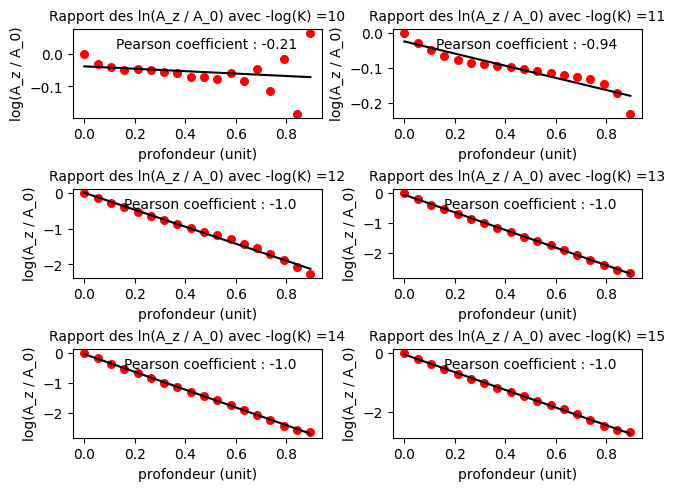

In [278]:
# Plot for different values of K

# returns profile temperature for a given value of K
def temperature_K(moinslog10IntrinK):
    layers_list= layersListCreator([(name, Zbottom, moinslog10IntrinK, n, lambda_s, rhos_cs)])
    col_dict = {
        "river_bed": 1., 
        "depth_sensors": depth_sensors, #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
        "offset": .0,
        "dH_measures": emu_observ_test_user1._molonariP_data,
        "T_measures": emu_observ_test_user1._molonariT_data,
        "sigma_meas_P": sigma_meas_P,
        "sigma_meas_T": sigma_meas_T,
    }
    col = Column.from_dict(col_dict,verbose=False)
    col._compute_solve_transi_multiple_layers(layers_list, nb_cells, verbose=False)

    profil_temp = profil_temperature(dH_offset, moinslog10IntrinK)[:last_cell,:]
    return np.transpose(profil_temp)


def plot_for_several_Kvalues(list_of_log_K_values):
    T_list = []
    for l in list_of_log_K_values:
        T_list.append(temperature_K(l))

    plot_mosaic(depth_cells[0:last_cell], T_list, list_of_log_K_values)


plot_for_several_Kvalues(range_of_minus_log_10_K)